#MODELO CON SEGMENTACIÓN

#1. Preparación de los datos

In [26]:
## CARGA DE DATOS
## =============================================================================

!unrar x 'drive/MyDrive/TFM/Datasets/dataset_segmentation.rar'

Se han truncado las últimas 5000 líneas del flujo de salida.
Extracting  dataset_segmentation/train/Normal/Normal-2449.png             66%  OK 
Extracting  dataset_segmentation/train/Normal/Normal-2451.png             66%  OK 
Extracting  dataset_segmentation/train/Normal/Normal-2453.png             66%  OK 
Extracting  dataset_segmentation/train/Normal/Normal-2454.png             66%  OK 
Extracting  dataset_segmentation/train/Normal/Normal-2455.png             66%  OK 
Extracting  dataset_segmentation/train/Normal/Normal-2458.png             66%  OK 
Extracting  dataset_segmentation/train/Normal/Normal-2459.png             66%  OK 
Extracting  dataset_segmentation/train/Normal/Normal-246.png              66%  OK 
Extracting  dataset_segmentation/train/Normal/Normal-2460.png             66%  OK 
Extracting  dataset_segmentation/train/Normal/Normal-2464.png             66%  OK 
Extracting  dataset

In [27]:
## ACELERACIÓN POR GPU
## =============================================================================

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6889563376542458502, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11345264640
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4661314029640028861
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [29]:
## Uso de Tensorflow 2.
## =============================================================================

%tensorflow_version 2.x

In [31]:
## IMPORTACIÓN DE LAS LIBRERIAS NECESARIAS
## =============================================================================

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.models    import Sequential, load_model
from tensorflow.keras.layers    import Flatten, Dense, Activation, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from functools import partial
from tensorflow.keras.regularizers import L2
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNet

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # imprime en pantalla el resultado de todos los statements

In [32]:
# Directorios
base_dir =  'drive/MyDrive/TFM/Segmentacion/Conv-Regular'
train_dir = 'dataset_segmentation/train'
test_dir  = 'dataset_segmentation/test'

In [33]:
## GENERADOR DE IMÁGENES 'grayscale' (Ayuda a cargar y transformar las imágenes por lotes )
## =============================================================================

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (224, 224),                 
        batch_size  = 32,
        shuffle=True,
        color_mode='grayscale',
        class_mode  ='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (224, 224),
        batch_size  = 32,
        shuffle=True,
        color_mode='grayscale',
        class_mode  = 'categorical')

Found 13178 images belonging to 4 classes.
Found 3296 images belonging to 4 classes.


##1. Red convolucional 1

In [ ]:
## DEFINICIÓN DE LA TOPOLOGÍA DE LA RED NEURONAL
## ====================================================

DefaultConv2D = partial(Conv2D,
                         kernel_size=3, 
                         activation='relu',
                         padding='same',
                         strides=1,
                         kernel_regularizer =L2(0.01))

model = Sequential([
    
    # CONV1 Y MAX-POOLING1                           
    DefaultConv2D(filters=32, input_shape=[224, 224, 1]),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV2 & CONV3 Y MAX-POOLING2
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV4 Y MAX-POOLING3
    DefaultConv2D(filters=64),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV5 Y MAX-POOLING4
    DefaultConv2D(filters=128),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
   
    # CONV6 Y MAX-POOLING5
    DefaultConv2D(filters=256),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV7 Y MAX-POOLING6
    DefaultConv2D(filters=256),
    MaxPooling2D(pool_size=3),
    BatchNormalization(),

    # APLANADO Y RED CLÁSICA
    Flatten(),
    Dropout(0.4),
    Dense(units=32, activation='relu'),
    Dense(units=4, activation='softmax'),

])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        2

In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(loss='categorical_crossentropy', 
               optimizer= 'adam',
               metrics=['accuracy'])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir +'segmentation.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(
                  train_generator,
                  epochs=60,
                  validation_data= test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'segmentation.npy', history.history)

Epoch 1/60
412/412 [==============================] - 100s 166ms/step - loss: 4.4511 - accuracy: 0.6635 - val_loss: 5.3345 - val_accuracy: 0.2051
Epoch 2/60
412/412 [==============================] - 66s 160ms/step - loss: 1.4284 - accuracy: 0.7214 - val_loss: 2.3078 - val_accuracy: 0.2667
Epoch 3/60
412/412 [==============================] - 66s 159ms/step - loss: 1.1181 - accuracy: 0.7319 - val_loss: 1.3201 - val_accuracy: 0.7005
Epoch 4/60
412/412 [==============================] - 65s 159ms/step - loss: 1.0406 - accuracy: 0.7484 - val_loss: 1.2660 - val_accuracy: 0.6353
Epoch 5/60
412/412 [==============================] - 65s 158ms/step - loss: 0.9979 - accuracy: 0.7536 - val_loss: 1.4065 - val_accuracy: 0.5343
Epoch 6/60
412/412 [==============================] - 65s 158ms/step - loss: 1.0034 - accuracy: 0.7605 - val_loss: 1.3487 - val_accuracy: 0.6214
Epoch 7/60
412/412 [==============================] - 65s 158ms/step - loss: 0.9796 - accuracy: 0.7585 - val_loss: 1.7177 - val_a

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'segmentation.h5')
history = np.load(base_dir + 'segmentation.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

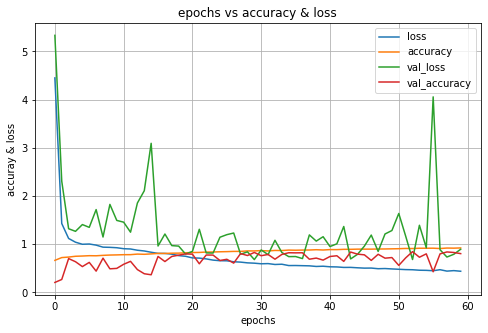

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 9s 84ms/step - loss: 0.8943 - accuracy: 0.8034


In [ ]:
## PREDICCIÓN DEL DATASET DE PRUEBA
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([1, 1, 2, ..., 3, 3, 3])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CATEGORÍAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

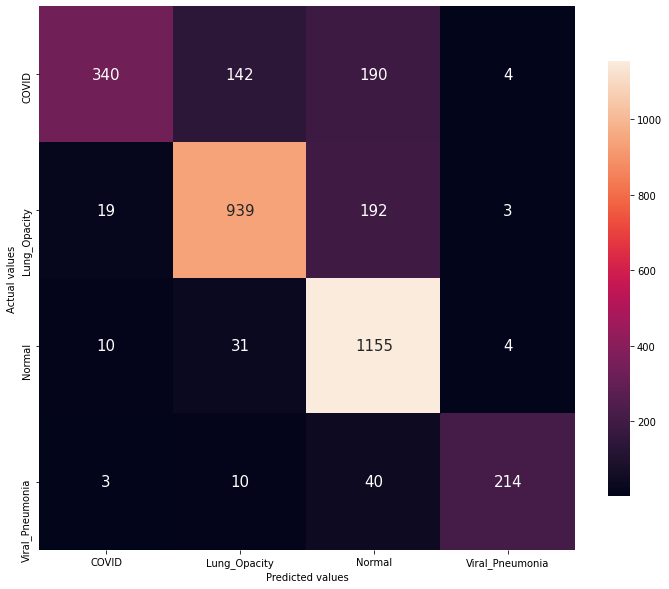

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualización)
## ======================================================

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## METRICAS
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.91      0.50      0.65       676
   Lung_Opacity       0.84      0.81      0.83      1153
         Normal       0.73      0.96      0.83      1200
Viral_Pneumonia       0.95      0.80      0.87       267

       accuracy                           0.80      3296
      macro avg       0.86      0.77      0.79      3296
   weighted avg       0.82      0.80      0.80      3296



##2. Aumento de filtros convolucionales (red convolucional 4)

In [ ]:
## DEFINICIÓN DE LA TOPOLOGÍA DE LA RED NEURONAL
## ====================================================

DefaultConv2D = partial(Conv2D,
                         kernel_size=3, 
                         activation='relu',
                         padding='same',
                         strides=1,
                         kernel_regularizer =L2(0.01))

model = Sequential([
    
    # CONV1 Y MAX-POOLING1                           
    DefaultConv2D(filters=32, input_shape=[224, 224, 1]),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV2 & CONV3 Y MAX-POOLING2
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV4 & CONV5 Y MAX-POOLING3
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV6 & CONV7 Y MAX-POOLING4
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
   
    # CONV8 & CONV9 Y MAX-POOLING5
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV10 & CONV11 Y MAX-POOLING6
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    MaxPooling2D(pool_size=3),
    BatchNormalization(),

    # APLANADO Y RED CLÁSICA
    Flatten(),
    Dropout(0.4),
    Dense(units=32, activation='relu'),
    Dense(units=4, activation='softmax'),

])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        2

In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(loss='categorical_crossentropy', 
               optimizer= 'adam',
               metrics=['accuracy'])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir +'model_MoreConv.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(
                  train_generator,
                  epochs=60,
                  validation_data= test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'history_MoreConv.npy', history.history)

Epoch 1/60
412/412 [==============================] - 111s 191ms/step - loss: 7.7687 - accuracy: 0.6594 - val_loss: 4.8588 - val_accuracy: 0.2051
Epoch 2/60
412/412 [==============================] - 76s 185ms/step - loss: 1.8545 - accuracy: 0.6983 - val_loss: 1.8923 - val_accuracy: 0.3656
Epoch 3/60
412/412 [==============================] - 76s 185ms/step - loss: 1.1392 - accuracy: 0.7126 - val_loss: 1.2872 - val_accuracy: 0.6174
Epoch 4/60
412/412 [==============================] - 76s 185ms/step - loss: 0.9773 - accuracy: 0.7154 - val_loss: 1.0463 - val_accuracy: 0.6693
Epoch 5/60
412/412 [==============================] - 76s 185ms/step - loss: 0.9025 - accuracy: 0.7283 - val_loss: 1.2914 - val_accuracy: 0.5995
Epoch 6/60
412/412 [==============================] - 76s 184ms/step - loss: 0.8631 - accuracy: 0.7414 - val_loss: 1.2271 - val_accuracy: 0.5695
Epoch 7/60
412/412 [==============================] - 76s 184ms/step - loss: 0.8173 - accuracy: 0.7503 - val_loss: 1.0637 - val_a

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'model_MoreConv.h5')
history = np.load(base_dir + 'history_MoreConv.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

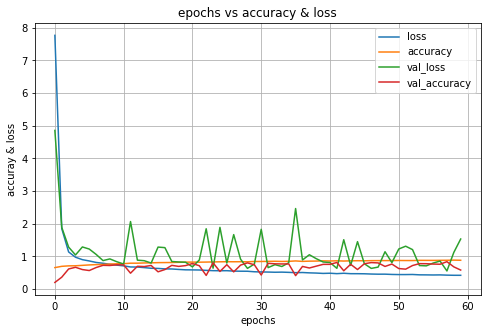

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO 
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 8s 80ms/step - loss: 1.5345 - accuracy: 0.5840


In [ ]:
## PREDICCIÓN DEL MODELO
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CAREGORIAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

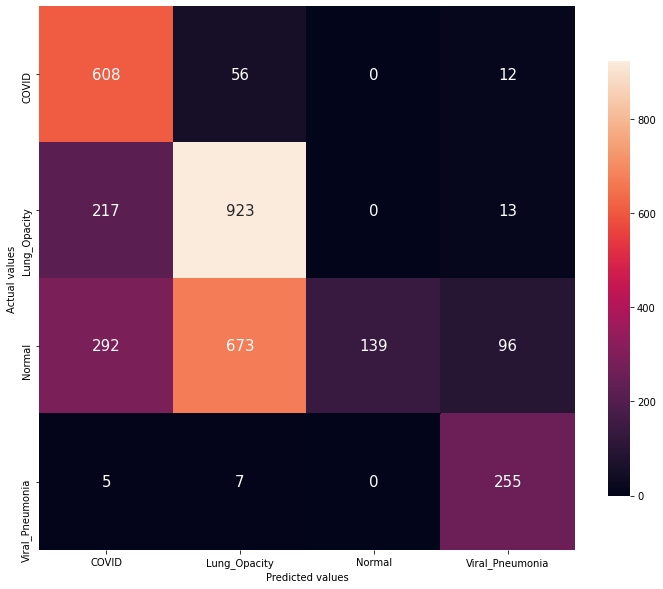

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualización)
## ======================================================

import seaborn as sns

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## Métricas
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.54      0.90      0.68       676
   Lung_Opacity       0.56      0.80      0.66      1153
         Normal       1.00      0.12      0.21      1200
Viral_Pneumonia       0.68      0.96      0.79       267

       accuracy                           0.58      3296
      macro avg       0.69      0.69      0.58      3296
   weighted avg       0.72      0.58      0.51      3296



##3. Aumento de filtros en las primeras capas (red convolucional 2)

In [ ]:
## DEFINICIÓN DE LA TOPOLOGÍA DE LA RED NEURONAL
## =============================================================================

DefaultConv2D = partial(Conv2D,
                         kernel_size=3, 
                         activation='relu',
                         padding='same',
                         strides=1,
                         kernel_regularizer =L2(0.01))

model = Sequential([
    
    # CONV1 Y MAX-POOLING1                           
    DefaultConv2D(filters=32, input_shape=[224, 224, 1]),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV2 & CONV3 Y MAX-POOLING2
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV4 & CONV5 Y MAX-POOLING3
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV6 & CONV7 Y MAX-POOLING4
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
   
    # CONV8 & CONV9 Y MAX-POOLING5
    DefaultConv2D(filters=256),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV10 & CONV11 Y MAX-POOLING6
    DefaultConv2D(filters=256),
    MaxPooling2D(pool_size=3),
    BatchNormalization(),

    # APLANADO Y RED CLÁSICA
    Flatten(),
    Dropout(0.4),
    Dense(units=32, activation='relu'),
    Dense(units=4, activation='softmax'),

])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 56, 56, 64)       

In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(loss='categorical_crossentropy', 
               optimizer= 'adam',
               metrics=['accuracy'])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir +'first_MoreConv.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(
                  train_generator,
                  epochs=60,
                  validation_data= test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'history_firstConv.npy', history.history)

Epoch 1/60
412/412 [==============================] - 115s 206ms/step - loss: 6.5760 - accuracy: 0.6556 - val_loss: 7.9448 - val_accuracy: 0.2051
Epoch 2/60
412/412 [==============================] - 83s 200ms/step - loss: 1.9387 - accuracy: 0.6854 - val_loss: 2.6173 - val_accuracy: 0.4038
Epoch 3/60
412/412 [==============================] - 82s 200ms/step - loss: 1.2555 - accuracy: 0.6977 - val_loss: 1.2674 - val_accuracy: 0.6614
Epoch 4/60
412/412 [==============================] - 82s 199ms/step - loss: 1.0698 - accuracy: 0.7153 - val_loss: 2.4221 - val_accuracy: 0.2834
Epoch 5/60
412/412 [==============================] - 82s 199ms/step - loss: 1.0188 - accuracy: 0.7189 - val_loss: 1.9720 - val_accuracy: 0.5018
Epoch 6/60
412/412 [==============================] - 81s 198ms/step - loss: 0.9728 - accuracy: 0.7355 - val_loss: 1.0950 - val_accuracy: 0.6796
Epoch 7/60
412/412 [==============================] - 81s 197ms/step - loss: 0.9467 - accuracy: 0.7402 - val_loss: 1.3518 - val_a

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'first_MoreConv.h5')
history = np.load(base_dir + 'history_firstConv.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

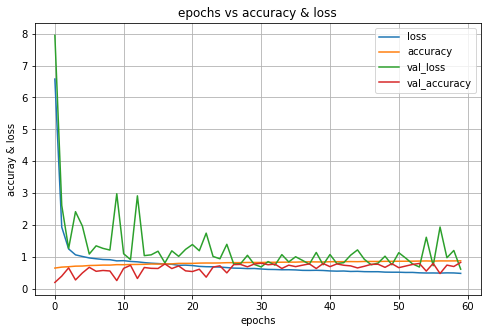

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 9s 87ms/step - loss: 0.6214 - accuracy: 0.8337


In [ ]:
## PREDICCIÓN DEL MODELO
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([1, 1, 2, ..., 3, 3, 3])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CATEGORIAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

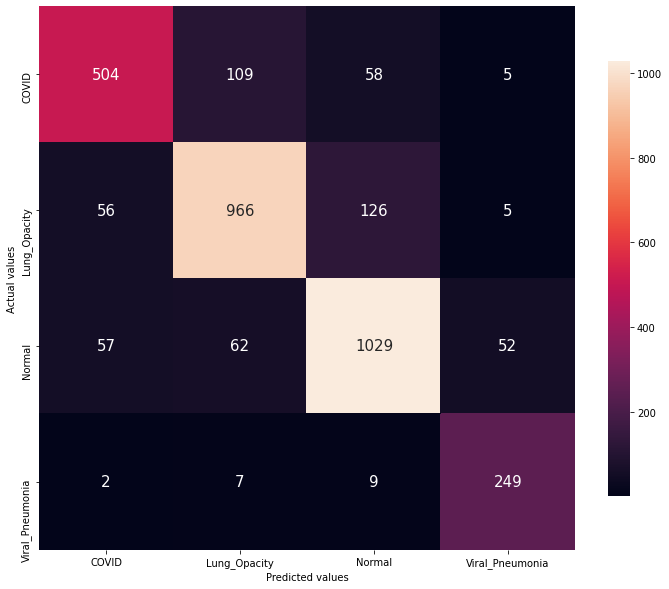

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualización)
## ======================================================

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## Métricas
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.81      0.75      0.78       676
   Lung_Opacity       0.84      0.84      0.84      1153
         Normal       0.84      0.86      0.85      1200
Viral_Pneumonia       0.80      0.93      0.86       267

       accuracy                           0.83      3296
      macro avg       0.83      0.84      0.83      3296
   weighted avg       0.83      0.83      0.83      3296



##4. Transfer-Learning: MobileNet (Modelo Base + 2 capas densas + últimas capas entrenables)

In [51]:
## GENERADOR DE IMÁGENES 'rgb' (Ayuda a cargar y transformar las imágenes por lotes )
## =============================================================================

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,                 
        target_size = (224, 224), 
        batch_size  = 32,
        shuffle=False,
        color_mode='rgb',
        class_mode  ='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (224, 224),
        batch_size  = 32,
        shuffle=False,
        color_mode='rgb',
        class_mode  = 'categorical')

Found 13178 images belonging to 4 classes.
Found 3296 images belonging to 4 classes.


In [42]:
## DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL
## =============================================================================

base_model = MobileNet(weights="imagenet",
                  include_top=False)

base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 

In [43]:
## DESBLOQUEO DE ÚLTIMAS CAPAS ENTRENABLES
## =============================================================================

base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['conv_pw_13', 'conv_pw_13_bn']:
        layer.trainable = True
    else:
        layer.trainable = False 

In [44]:
## AÑADIDO DE 2 CAPAS DENSAS
## =============================================================================

out = GlobalAveragePooling2D()(base_model.output)
out = Dense(1024, activation = 'relu')(out)
out = Dropout(0.4)(out)
out = Dense(512, activation='relu')(out)
out = Dropout(0.4)(out)
out = Dense(4, activation='softmax')(out)
model = Model(inputs = base_model.input, outputs = out)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 32)    0     

In [45]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(loss="categorical_crossentropy",
              optimizer='sgd',
              metrics=["accuracy"])

In [46]:
## ENTRENAMIENTO DEL MODELO
## ======================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir + 'MobileNet_Last_Layer_Trainable_model.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(train_generator, 
                  epochs=100,
                  validation_data=test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'MobileNet_Last_Layer_Trainable_history.npy', history.history)

Epoch 1/100
412/412 [==============================] - 55s 129ms/step - loss: 1.1076 - accuracy: 0.5401 - val_loss: 0.7607 - val_accuracy: 0.6902
Epoch 2/100
412/412 [==============================] - 52s 126ms/step - loss: 0.8514 - accuracy: 0.6551 - val_loss: 0.6716 - val_accuracy: 0.7406
Epoch 3/100
412/412 [==============================] - 53s 128ms/step - loss: 0.7741 - accuracy: 0.6905 - val_loss: 0.6299 - val_accuracy: 0.7555
Epoch 4/100
412/412 [==============================] - 51s 125ms/step - loss: 0.7313 - accuracy: 0.7097 - val_loss: 0.6038 - val_accuracy: 0.7652
Epoch 5/100
412/412 [==============================] - 51s 124ms/step - loss: 0.6994 - accuracy: 0.7249 - val_loss: 0.5861 - val_accuracy: 0.7688
Epoch 6/100
412/412 [==============================] - 52s 125ms/step - loss: 0.6704 - accuracy: 0.7341 - val_loss: 0.5722 - val_accuracy: 0.7755
Epoch 7/100
412/412 [==============================] - 51s 125ms/step - loss: 0.6398 - accuracy: 0.7478 - val_loss: 0.5602 -

In [47]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'MobileNet_Last_Layer_Trainable_model.h5')
history = np.load(base_dir + 'MobileNet_Last_Layer_Trainable_history.npy', allow_pickle='TRUE').item()

In [48]:
del history['lr']

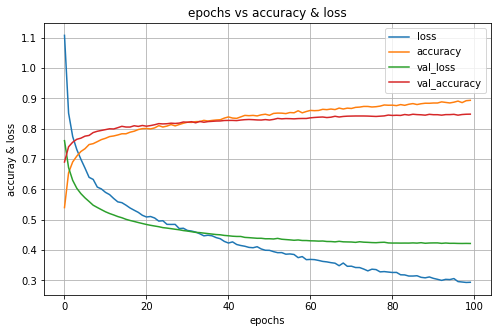

In [49]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [50]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 10s 100ms/step - loss: 0.4219 - accuracy: 0.8480


In [52]:
## PREDICCIÓN DEL DATASET DE PRUEBA
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([0, 1, 3, ..., 3, 3, 3])

In [53]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [54]:
## CATEGORÍAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

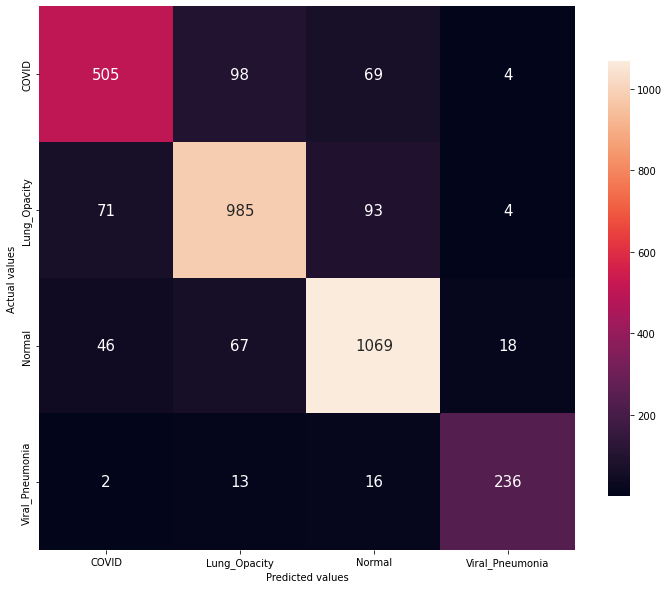

In [55]:
## MATRIZ DE CONFUSIÓN (Visualización)
## ======================================================

import seaborn as sns

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [56]:
## METRICAS
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.81      0.75      0.78       676
   Lung_Opacity       0.85      0.85      0.85      1153
         Normal       0.86      0.89      0.87      1200
Viral_Pneumonia       0.90      0.88      0.89       267

       accuracy                           0.85      3296
      macro avg       0.85      0.84      0.85      3296
   weighted avg       0.85      0.85      0.85      3296

